### Simple Linear Regression

This notebook explores the concept of Simple Linear Regression using a classic example: predicting house prices.

We'll utilize the houses_portland_simple dataset, a simplified CSV file containing two features (Size and Bedrooms) and a target variable (Price). This dataset will serve as our foundation for understanding how linear regression can be used to model the relationship between these variables and predict house prices.

In [21]:
#libraries
import numpy as np # linear algebra
import pandas as pd # read and wrangle dataframes
import matplotlib.pyplot as plt # visualization

from scratch_libraries.linear_regression import LinearRegression # our scratch implementation of Linear Regression

In [22]:
# read the dataset of houses prices
houses = pd.read_csv('./datasets/houses_portaland_simple.csv')

display(houses[:10])


,Size,Bedroom,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900
5,1985,4,299900
6,1534,3,314900
7,1427,3,198999
8,1380,3,212000
9,1494,3,242500


In [23]:
# print dataset stats
print(houses.describe())

              Size    Bedroom          Price
count    47.000000  47.000000      47.000000
mean   2000.680851   3.170213  340412.659574
std     794.702354   0.760982  125039.899586
min     852.000000   1.000000  169900.000000
25%    1432.000000   3.000000  249900.000000
50%    1888.000000   3.000000  299900.000000
75%    2269.000000   4.000000  384450.000000
max    4478.000000   5.000000  699900.000000


Since we are interested in Simple Linear Regression, we need to consider a single feature, for istance 'Size'. To isolate this feature, we will remove the 'Bedrooms' column from our dataset. This will leave us with a dataset containing only the 'Size' feature and the target variable, 'Price'.

In [24]:
# Remove the Bedroom column, so we can use simple linear regression
houses.drop('Bedroom', axis=1, inplace=True)

print(houses.head())

   Size   Price
0  2104  399900
1  1600  329900
2  2400  369000
3  1416  232000
4  3000  539900


In machine learning, it's crucial to shuffle the data before training the model. This prevents the model from favoring patterns based on the original order of the data.

In [25]:
# shuffling all the samples to avoid group bias (to avoid any ordering bias)
houses = houses.sample(frac=1, random_state=123).reset_index(drop=True)

Visualizing the data helps us understand the underlying relationship between features (like Size) and the target variable (Price). Here, we see a scatter plot having on x-axis size and on y-axis price where each dot represents a sample of our dataset. By looking for patterns, we can assess if a linear relationship might exist between size and price which would be the case if we notice that the data points appear to follow a straight line.

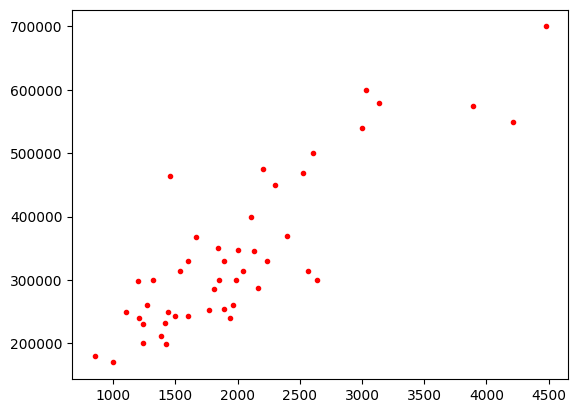

In [26]:
# Let's visualize our data plotting house size vs. price
plt.plot(houses.Size, houses.Price, 'r.') # to plot data as red (r) dots (.)
plt.show()

Another way to assess whether a linear relationship exists between our data is by examining the correlation coefficient, which quantifies the strength and direction of the linear relationship between two variables.
- A value close to 1 indicates a strong positive linear correlation,
- A value close to -1 indicates a strong negative linear correlation, and
- A value near 0 suggests little to no linear relationship.
This metric helps us determine whether linear regression is an appropriate modeling approach for the dataset.

In this case, we observe a high positive correlation coefficient (0.854988), which strongly suggests that our feature ('Size') and target ('Price') have a linear relationship. Therefore, a Linear Regression model is likely to perform well for this data.

This correlation analysis serves as additional confirmation, complementing the insight we gained from the earlier scatterplot visualization.

In [27]:
print(houses.corr()) # This calculates and prints the correlation matrix, allowing us to see the correlation between house size and price.

           Size     Price
Size   1.000000  0.854988
Price  0.854988  1.000000


Before training a model, an important preprocessing step is **normalization**. When features have vastly different ranges of values, it’s crucial to scale them to comparable ranges. This prevents the algorithm struggle to converge due to the differences in feature scales during gradient descent.

Normalization ensures that all features are scaled so that they fall within a similar range, improving computational efficiency and convergence during training.

In this case, we apply **Z-score normalization**, which rescales the feature ('Size') and target ('Price') to have a mean of 0 and a standard deviation of 1.

In [28]:
# Z-Score Normalization
houses = houses.values
print("First 5 dataset values (before normalization):\n", houses[:5])

mean = houses.mean(axis=0)
std = houses.std(axis=0)

houses = (houses - mean) / std

print("First 5 dataset values (after normalization):\n", houses[:5])

First 5 dataset values (before normalization):
 [[  1380 212000]
 [  2000 347000]
 [   852 179900]
 [  2609 499998]
 [  1200 299000]]
First 5 dataset values (after normalization):
 [[-7.89466782e-01 -1.03807621e+00]
 [-8.65999486e-04  5.32514582e-02]
 [-1.46104938e+00 -1.29756968e+00]
 [ 7.73743478e-01  1.29007331e+00]
 [-1.01841540e+00 -3.34776157e-01]]


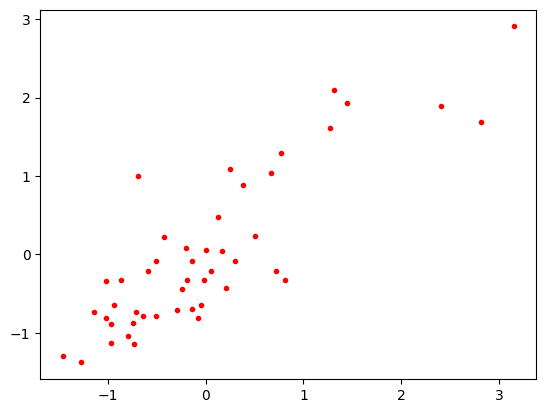

In [29]:
# Plot to show the new normalized values
x = houses[:, 0]
y = houses[:, 1]

plt.plot(x, y, 'r.')
plt.show()

To enable the model to learn an intercept (bias), we add a column of ones to $ x $. This bias term allows the regression line to shift vertically, improving the model's ability to fit the data.

In [30]:
# add bias column
x = np.c_[np.ones(x.shape[0]), x ] # Adds a bias (intercept) term to x by inserting a column of ones, allowing the model to learn an intercept.

print(x[:5])

[[ 1.00000000e+00 -7.89466782e-01]
 [ 1.00000000e+00 -8.65999486e-04]
 [ 1.00000000e+00 -1.46104938e+00]
 [ 1.00000000e+00  7.73743478e-01]
 [ 1.00000000e+00 -1.01841540e+00]]


 We are now ready to create a simple linear regression model, which can be expressed as:  

$$
h_\theta \left( x^{(i)} \right) = \theta_0 + \theta_1 x_1^{(i)}
$$

Recall that our goal is to predict house prices and to achieve this, we need to "fit" the model by finding the parameters $\theta$ (in this case, $\theta_0$ and $\theta_1$) that best approximate the relationship between the target variable (`Price`) and the feature (`Size`).  

To fit the model, we need to choose parameters such that the hypothesis $h_\theta$ is as close as possible to $y$ for the training examples. We saw that a way to measure this closeness is to use a **cost function** that quantifies the error between the predicted values and the actual target values. Moreover, we also saw that we can use as cost function the **Mean Squared Error (MSE)**, which is defined as:  

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2
$$

where:  
- $m$ is the number of training examples.  
- $h_\theta \left( x^{(i)} \right)$ is the predicted value from the hypothesis function.  
- $y^{(i)}$ is the actual target value.  

Therefore our ultimate goal is to find the parameters $\theta$ that minimize this cost function. Mathematically, this can be expressed as:  

$$
\theta_{\text{min}} = \underset{\theta}{\text{argmin}} \, J(\theta_0, \theta_1)
$$

We saw that an efficient method to minimize the cost function is the **Gradient Descent (GD)** algorithm. Gradient descent is an optimization technique that iteratively adjusts the model's parameters to minimize the cost. It follows the direction of the steepest descent (where the cost decreases most rapidly), determined by the gradient of the cost function.  

The steps for performing gradient descent are:  

1. **Initialize the Parameters**: Randomly initialize $\theta_0$ and $\theta_1$.  
2. **Update the Parameters**: The parameters are updated using their partial derivatives with respect to the cost function. The update rule is:  

   $$
   \theta_j \coloneqq \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}, \quad \alpha > 0
   $$

   where:  
   - $\frac{\partial}{\partial \theta_j} J(\theta_0, \theta_1)$ is the partial derivative of the cost function with respect to $\theta_j$.  
   - $\alpha$ is the **learning rate**, a hyperparameter that determines the step size in each iteration.  

   We derived the closed-form expression for the partial derivative of the cost function which is given by:  

   $$
   \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
   $$

   This formula is used during the gradient descent update step.  


In this implementation, we will use **Batch Gradient Descent (BGD)**, which considers **all** training examples to compute the gradient and perform a single update step. The update rule for BGD is:  

$$
\theta_j \coloneqq \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
$$

In the next notebook, we will explore two other gradient descent methods: **Stochastic Gradient Descent (SGD)** and **Mini-Batch Gradient Descent (MBGD)**.

---
### Matrix Representation of the Gradient  

In our case we operate on a dataset that basically follows this convention:  
- $X \in \mathbb{R}^{m \times n}$ is the input matrix, where each row represents a training sample and each column represents a feature.  
- $y \in \mathbb{R}^{m \times 1}$ is the output column vector (the target values).  

In such a case we can express the **gradient** (i.e., the vector of all partial derivatives) in matrix form as:  

$$
\nabla J(\theta) = \frac{1}{m} X^T \left( X\theta - y \right)
$$

This matrix formulation allows us to compute the gradient efficiently, operating directly with vectors and matrices without iterating through each training sample with a `for` loop.

---

We initialize a linear regression model with:
- `n_features=x.shape[1]`: Number of features, including the bias term.
- `n_steps=1000`: Number of iterations (epochs) for gradient descent (therefore, in this case we use a fixed number of epochs as the stopping condition of convergence).
- `learning_rate=0.01`: The step size for updating model parameters during training.
Note: The last two are hyperparameters.

In [31]:
# create a regressor with specific characteristics (with 1000 steps and a learning rate of 0.01)
linear = LinearRegression(n_features=x.shape[1], n_steps=1000, learning_rate=0.01)

At the start of training, the model parameters ($\theta$) are initialized randomly. Using these initial parameters, the model's hypothesis is represented as a straight line:  

$$
h_\theta \left( x^{(i)} \right) = \theta_0 + \theta_1 x_1^{(i)}
$$

We can visualize this initial hypothesis below. As expected, the line does not fit the data well, highlighting the need for training to adjust the parameters and improve the model.

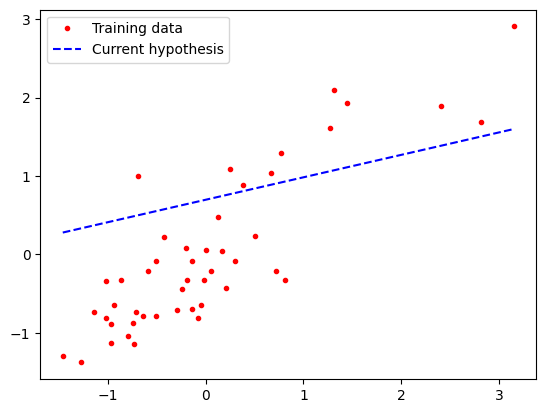

In [32]:
# Before fitting
# Let's create a line that represents our model’s current hypothesis. 
# We generate it based on the current values of our model’s parameters (theta) that at the begin are random. 
lineX = np.linspace(x[:, 1].min(), x[:, 1].max(), 100) # generates 100 evenly spaced values between the minimum and maximum normalized values of our feature (Size)
liney = [linear.theta[0] + linear.theta[1]*xx for xx in lineX] # create a list of predicted prices for each corresponding house size in lineX, where the predicted price is computed as y = theta_0 + theta_1*x

plt.plot(x[:, 1], y, 'r.', label='Training data')
plt.plot(lineX, liney, 'b--', label='Current hypothesis')
plt.legend()
plt.show()

Next, we train our model by applying full batch gradient descent to the training set. The fit method returns the evolution history of training costs and the new optimized parameters values ($\theta_0$ and $\theta_1$) after training.


In [33]:
# fit your trained regressor (recording cost history and theta values at each step)
cost_history, theta_history = linear.fit_fullbatch(x, y)

print(f'''Thetas: {*linear.theta,}''') # unpacks the elements of linear.theta, which include the theta_0 and theta_1 paramters after training, as individual values within a formatted string.
print(f'''Final train cost:  {cost_history[-1]:.3f}''') # retrieves the last value in cost_history formatting it to three decimal places.

Thetas: (3.006744352525792e-05, 0.8549630349892431)
Final train cost:  0.134


In [34]:
# Here we can see how the paramters have changed during BGD iterations. The last ones are the parameters value after after the last iteration.
print(theta_history)

[[6.89504494e-01 2.91827818e-01]
 [6.82609449e-01 2.97459415e-01]
 [6.75783354e-01 3.03034697e-01]
 ...
 [3.06779344e-05 8.54962536e-01]
 [3.03711551e-05 8.54962787e-01]
 [3.00674435e-05 8.54963035e-01]]


In [35]:
print("theta_0 (after training): ", theta_history[-1, 0])
print("theta_1 (after training): ", theta_history[-1, 1])

theta_0 (after training):  3.006744352525792e-05
theta_1 (after training):  0.8549630349892431


**Visualizing the final hypothesis** : After training, we can plot the model’s final hypothesis using these last values of theta from training.

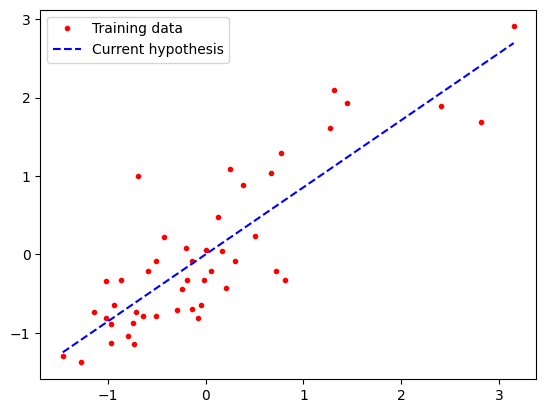

In [36]:
# After fitting
lineX = np.linspace(x[:, 1].min(), x[:, 1].max(), 100)
liney = [theta_history[-1, 0] + theta_history[-1, 1]*xx for xx in lineX] 
# Note: theta_history[-1, 0] takes the last array of the theta_history arrays (which to the final value after training) and 
# of it takes the first element which is the bias

plt.plot(x[:, 1], y, 'r.', label='Training data')
plt.plot(lineX, liney, 'b--', label='Current hypothesis')
plt.legend()
plt.show()

**Visualizing the Cost History**: This plot shows the evolution of the cost function over training iterations. A decreasing trend indicates that the model is converging towards a solution. It provides a visual confirmation that gradient descent is working effectively.

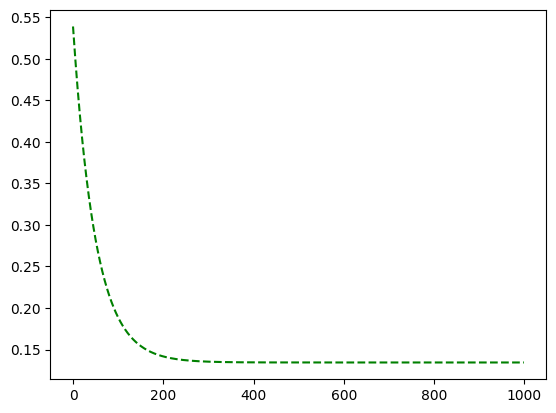

In [37]:
plt.plot(cost_history, 'g--')
plt.show()

#### Visualizing the Cost Function with a Contour Plot
At the end, below we plot the Contour Plot of the Cost Function. A contour plot is a graphical representation of a 3D surface in 2D, where each contour line connects points of equal cost. In this case, the x-axis and y-axis represent the parameters $\theta_0$ (bias) and $\theta_1$ (weight), while the contour levels correspond to specific cost values $J(\theta_0, \theta_1)$.  

This plot allows us to visualize how the cost function behaves across different parameter values. By examining the contours:
- We can observe how the cost decreases as $\theta_0$ and $\theta_1$ approach the optimal values that minimize the cost function.  
- The path traced by the model during training, as shown by the red dashed line, illustrates how gradient descent iteratively updates the parameters to reach the minimum cost.


In [38]:
# VISUALIZE COST FUNCTION (AS A CONTOUR PLOT)
# This help us in understanding how the cost changes with different parameter values.

# Step 1: Define the Range for theta0 and theta1
#Grid over which we will calculate J
theta0_vals = np.linspace(-2, 2, 100) # theta0_vals is a range of 100 values between -2 and 2, representing different values for the parameter theta0 (bias).
theta1_vals = np.linspace(-2, 3, 100) # theta1_vals is a range of 100 values between -2 and 3, representing different values for the parameter theta1 (weight)

# Step 2: Initialize a Cost Matrix
# This is a matrix of zeros, where each element will store a computed cost value.
J_vals = np.zeros((theta0_vals.size, theta1_vals.size)) # dimensions 100 x 100

#Fill out J_vals
# We iterate over each combination of theta0 and theta1 values.
for t0, theta0 in enumerate(theta0_vals):
    for t1, theta1 in enumerate(theta1_vals):
        # For each pair, a temporary thetaT array is created, which represents a candidate parameter vector, [theta0, theta1].
        thetaT = np.zeros(shape=(2, 1)) # it's an array of cloumn vectors (so it's the trasponse of theta)
        thetaT[0][0] = theta0
        thetaT[1][0] = theta1
        h = x.dot(thetaT.flatten()) # calculates the predictions h for each x using the current values of theta0 and theta1 (in thetaT). 
        # Note: thetaT.flatten() converts thetaT to a 1D array, making it compatible with x.dot()
        j = (h - y) # calculates the residuals (differences between predicted values h and actual values y).
        J = j.dot(j) / 2 / (len(x)) # computes the Mean Squared Error (MSE) cost
        J_vals[t0, t1] = J # This J value is stored in J_vals[t1, t2], recording the cost for this particular combination of parameters.

print(J_vals)

[[6.20997519 6.06705927 5.92669412 ... 4.22347082 4.32797864 4.43503722]
 [6.12998335 5.98706744 5.84670228 ... 4.14347898 4.2479868  4.35504538]
 [6.051624   5.90870808 5.76834293 ... 4.06511963 4.16962745 4.27668603]
 ...
 [6.051624   5.90870808 5.76834293 ... 4.06511963 4.16962745 4.27668603]
 [6.12998335 5.98706744 5.84670228 ... 4.14347898 4.2479868  4.35504538]
 [6.20997519 6.06705927 5.92669412 ... 4.22347082 4.32797864 4.43503722]]


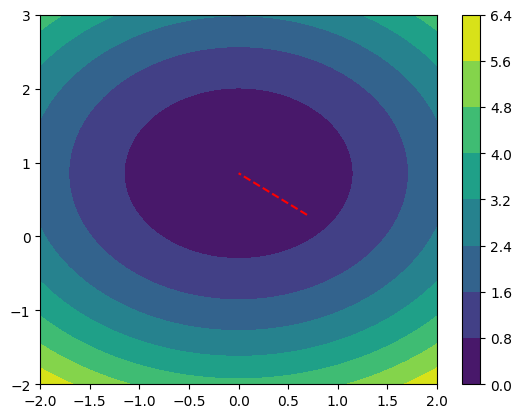

In [39]:
#Contour plot
J_vals = J_vals.T # transpose of J_vals matrix
# This will represent height values over which the contour is drawn.

# Let's create a two 2D arrays, A and B, from the theta0_vals and theta1_vals ranges, where:
#    - A represents theta0 values across the x-axis.
#    - B represents theta1 values across the y-axis.
# C is set to J_vals, representing the cost values corresponding to each (theta0, theta1) pair. 
# So, like that each point (A, B) on the grid corresponds to a cost in C.
A, B = np.meshgrid(theta0_vals, theta1_vals) 
C = J_vals

cp = plt.contourf(A, B, C) # generates a filled contour plot of J (cost) as a function of theta0 and theta1.
# A and B form the x and y axes (representing theta0 and theta1), while C provides the levels (contours) representing different cost values.
plt.colorbar(cp) #  adds a color bar next to the plot, showing the cost values corresponding to different contour colors.
plt.plot(theta_history.T[0], theta_history.T[1], 'r--') # Plot the path of theta values over time showing how these theta changes
# during training as it moves toward the optimal cost.
plt.show()